# Analyses - Figure 4: RNA velocity estimation EEC

In [1]:
import scvelo as scv
scv.logging.print_version()
import scanpy as sc
import numpy as np

Running scvelo 0.1.26.dev7+g5e6d395 (python 3.7.4) on 2020-03-08 18:48.


In [3]:
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.0 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
scv.settings.verbosity = 3  
scv.settings.set_figure_params('scvelo') 

subset data to EECs from CD mice

In [9]:
adata_all = sc.read('./data/adata_processed.h5')

In [10]:
adata_eec = adata_all[adata_all.obs.groups_named_prog4.isin(['EE progenitor', 'EEC'])].copy()

In [ ]:
# subset to CD cells
adata_eec_cd = adata_eec[adata_eec.obs['diet'].isin(['CD'])].copy()

# exclude Lgr5+ EEC
adata_eec_cd = adata_eec_cd[np.invert(adata_eec_cd.obs['groups_named_eec'].isin(['Lgr5+ EEC']))].copy()

Load velocyto data  
**Note:**
Splicing information of reads (spliced/unspliced) was extracted using the velocyto pipeline (http://velocyto.org), 
stored in a loompy file and then read into an AnnData object for downstream analysis with scVelo and Scanpy and saved as adata_velocyto.h5

In [13]:
adata_velocyto = sc.read('./data/adata_velocyto.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


subset velocyto data to overlapping EECs from CD mice and copy annotations

In [ ]:
ix = list(set(adata_velocyto.obs_names).intersection(adata_eec_cd.obs_names))

In [ ]:
adata_velocyto_cd = adata_velocyto[ix, :].copy()

In [ ]:
adata_eec_cd = adata_eec_cd[ix, :].copy()

In [20]:
adata_velocyto_cd.obsm['X_umap'] = adata_eec_cd.obsm['X_umap']
adata_velocyto_cd.obs['groups_named_eec_final'] = adata_eec_cd.obs['groups_named_eec_final']
adata_velocyto_cd.uns['groups_named_eec_final_colors'] = adata_eec_cd.uns['groups_named_eec_final_colors']

## CD

In [10]:
scv.pp.filter_and_normalize(adata_velocyto_cd, min_shared_counts=20, n_top_genes=4000,min_cells_u=10)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 17931 genes that are detected in less than 10 cells (unspliced).
Filtered out 4027 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [11]:
scv.pp.pca(adata_velocyto_cd)

In [12]:
scv.pp.moments(adata_velocyto_cd, n_pcs=25, n_neighbors=15)

computing neighbors
    finished (0:00:02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [13]:
scv.tl.recover_dynamics(adata_velocyto_cd)

recovering dynamics
    finished (0:06:17) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [14]:
scv.tl.velocity(adata_velocyto_cd, mode='dynamical',min_likelihood=0.1,min_r2=0.5)
scv.tl.velocity_graph(adata_velocyto_cd)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [15]:
np.sum(adata_velocyto_cd.var['velocity_genes'])

291

In [17]:
# shorten names for plotting
adata_velocyto_cd.obs['groups_named_eec_short'] = adata_velocyto_cd.obs['groups_named_eec_final']
adata_velocyto_cd.obs['groups_named_eec_short'] = adata_velocyto_cd.obs['groups_named_eec_short'].cat.rename_categories(['Sox4+ \n EEP', 'Ngn3+ \n EEP', 'Arx+/Isl1+ P', 
                                                                                                                         'Pax4+ P', 'Ghrl+ P', 'SILA', 'SILP', 'SAKD', 
                                                                                                                         'SIK', 'Reg4+ EC', 'EC'])
adata_velocyto_cd.uns['groups_named_eec_short_colors'] = adata_velocyto_cd.uns['groups_named_eec_colors']

saving figure to file ./figures/scvelo_.svg


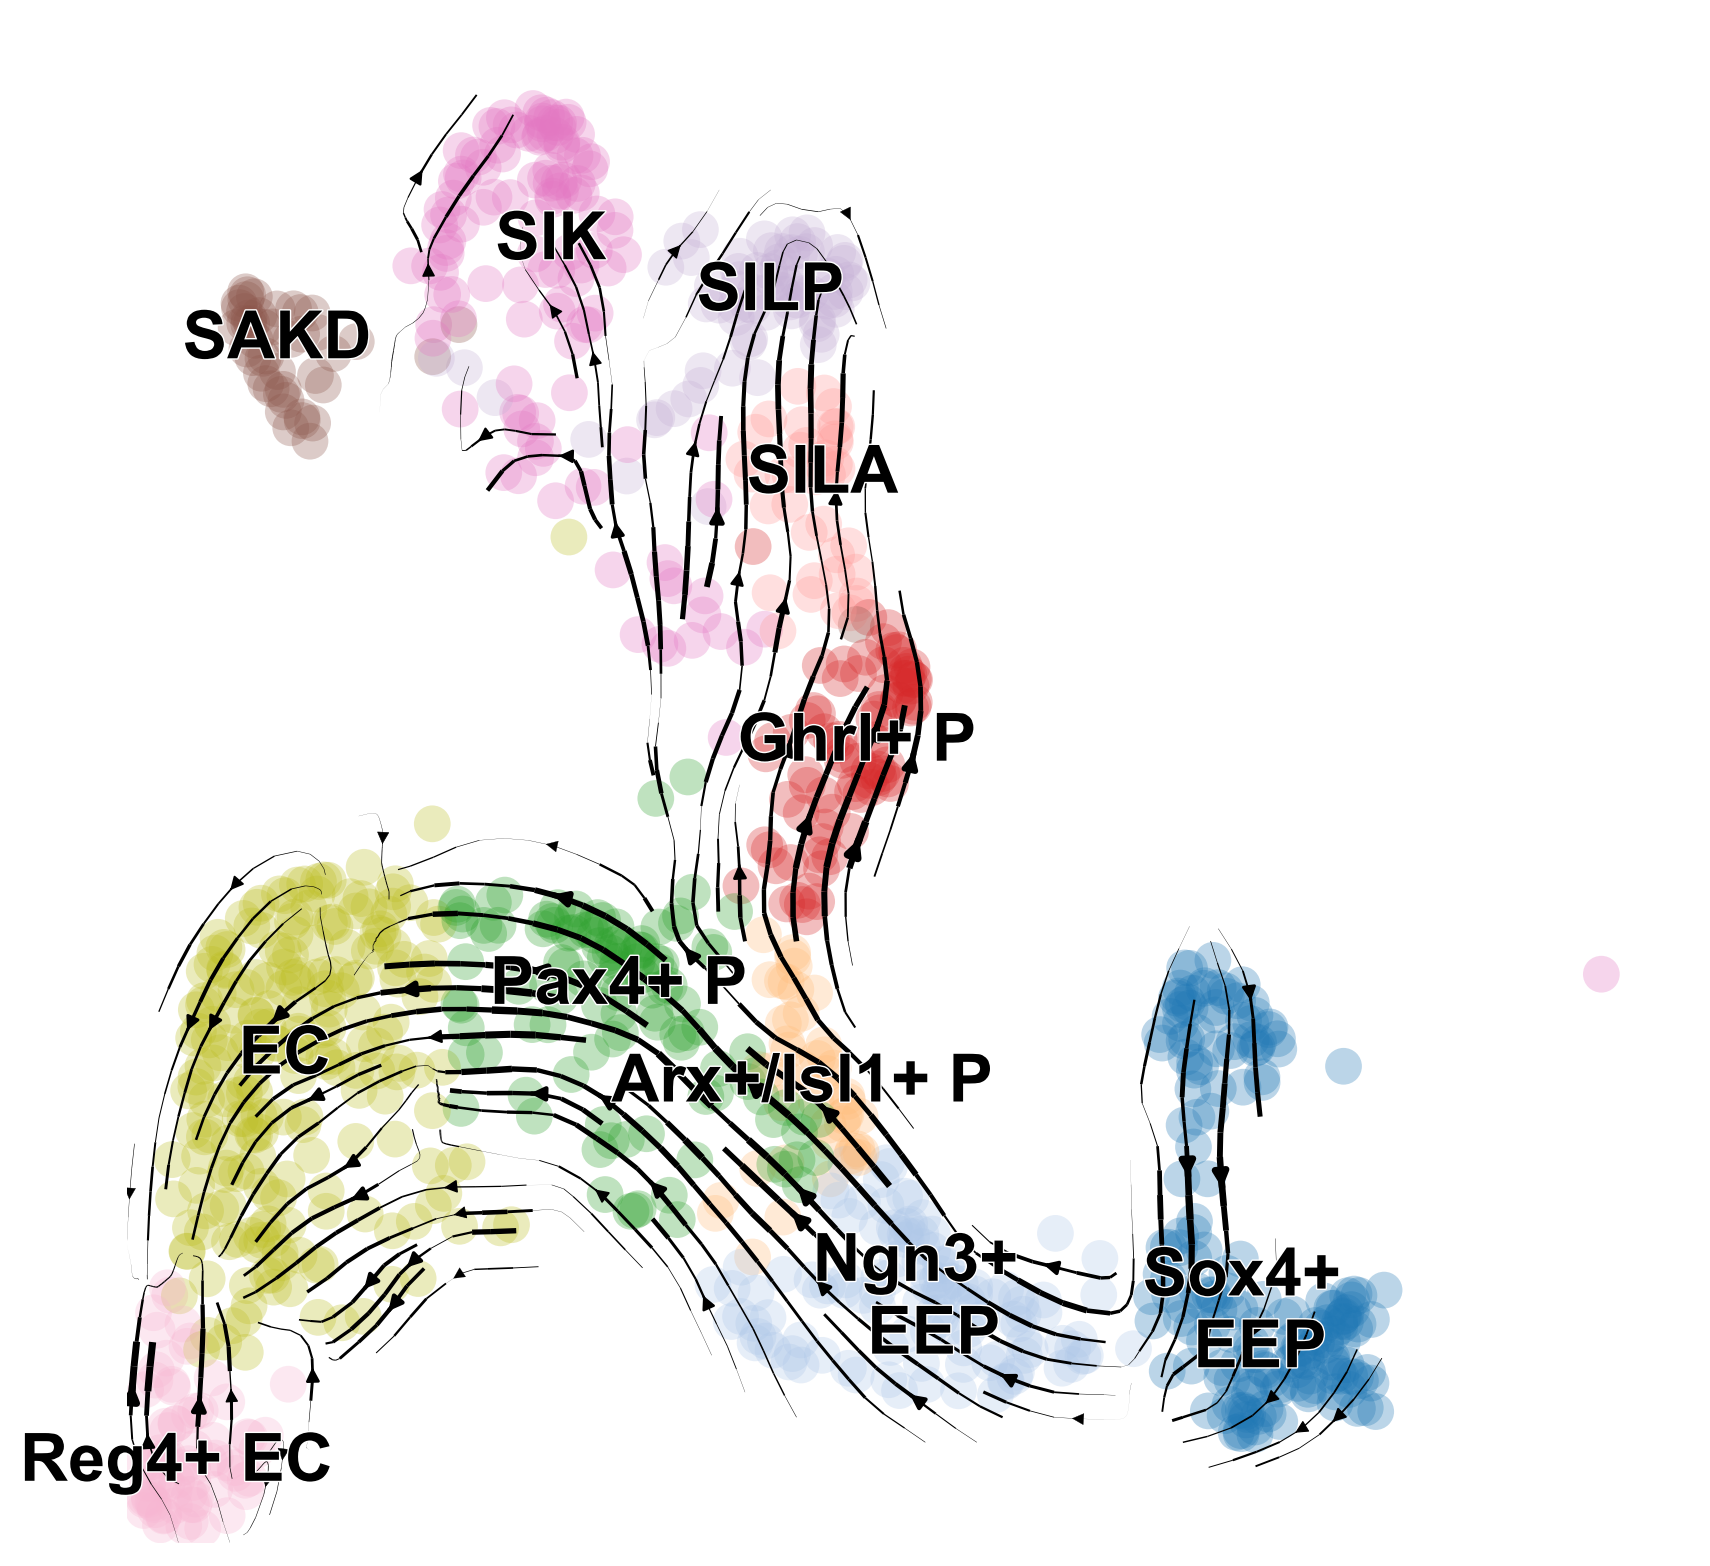

In [4]:
scv.set_figure_params('scvelo',figsize=(10,10))
scv.pl.velocity_embedding_stream(adata_velocyto_cd, basis='umap',color='groups_named_eec_short',legend_fontsize=24, 
                                 legend_loc='on data', title='', linewidth=1.5, size=700, save='.svg')